# Content Based Image Retrieval (CBIR)
## Approach:

- By observing the data its pretty clear that an Unsupervised alongwith couple of different Hashing approachs will be the most commendable. Although there are number of techniques in that area as well, we'll focus on Hashing and Auto-Encoder techniques:
    
    - ***Latent Feature Extraction***: In this technique we can find feature vectors for every image by creating hooks on a pre-trained network and extracting the vector from previous layers. Other technique devises the use of **AutoEncoders** where the Latent features can be extracted from Encoder itself. For the sake of this data we'll proceed with AutoEncoders. For the retrieval part we'll look into Euclidean based Search (O(NlogN)) and Hashing Based Approaches (O(logN)).
    <br>
    - ***Image Hashing Search***: This can be done by:
        - Uniquely quantify the contents of an image using only a single integer.
        - Find duplicate or near-duplicate images in a dataset of images based on their computed hashes.<br>
        <br>
      This can be accomplished by a specialized data structure called a **VP-Tree**. Using a VP-Tree we can reduce our search complexity from O(nlogn) to O(log n), enabling us to obtain our sub-linear goal!

In [1]:
import time
import copy
import pickle
#from barbar import Bar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
import os

In [2]:
# Find if any accelerator is presented, if yes switch device to use CUDA or else use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# preparing intermediate DataFrame
datasetPath = Path('oxford_buildings - Full/')
df = pd.DataFrame()

df['image'] = [f for f in os.listdir(datasetPath) if os.path.isfile(os.path.join(datasetPath, f))]
df['image'] = 'oxford_buildings - Full/' + df['image'].astype(str)

print(len(df))
df.head()

5063


image
0  oxford_buildings - Full/all_souls_000000.jpg
1  oxford_buildings - Full/all_souls_000001.jpg
2  oxford_buildings - Full/all_souls_000002.jpg
3  oxford_buildings - Full/all_souls_000003.jpg
4  oxford_buildings - Full/all_souls_000005.jpg

# Data Preparation

In [4]:
class CBIRDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor(),])#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = self.transformations(Image.open(row['image']))
        return image
    
    def __len__(self):
        return len(self.dataFrame.index)
    
# Intermediate Function to process data from the data retrival class
def prepare_data(DF):
    trainDF, validateDF = train_test_split(DF, test_size=0.2, random_state=0)
    train_set = CBIRDataset(trainDF)
    validate_set = CBIRDataset(validateDF)
    
    return train_set, validate_set

In [5]:
train_set, validate_set = prepare_data(DF=df)

NUM_BATCHES = 32

dataloaders = {'train': DataLoader(train_set, batch_size=NUM_BATCHES, shuffle=True, drop_last=True) ,
               'val':DataLoader(validate_set, batch_size=NUM_BATCHES, drop_last=True)}#, num_workers=0

dataset_sizes = {'train': len(train_set),'val':len(validate_set)}

# AutoEncoder Model

## High Level Structure of an AutoEncoder

![](https://hackernoon.com/hn-images/1*op0VO_QK4vMtCnXtmigDhA.png)

In [6]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.latent_dim = 100
        
        self.encoder = nn.Sequential(# in- (N,3,128,128)    
            # input going into a convolution
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.2),
            #
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.2),
            #
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.2),
            #
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.2),
            #
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.2),  
            #
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.2), 
            #
            nn.Conv2d(64, self.latent_dim, 3, padding=1, bias=False),
            nn.BatchNorm2d(self.latent_dim),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.2),    
        )
        
        self.decoder = nn.Sequential(  
            nn.ConvTranspose2d(self.latent_dim, 64, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            #nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. 64 
            nn.ConvTranspose2d(64, 64, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            #nn.Dropout(0.2),
            nn.ReLU(True),                                                                  
            # state size. 64 
            nn.ConvTranspose2d(64, 64, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            #nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. 64 
            nn.ConvTranspose2d(64, 64, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            #nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. 64
            nn.ConvTranspose2d(64, 64, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            #nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. 64
            nn.ConvTranspose2d(64, 64, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            #nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. outchanels = 3          
            nn.ConvTranspose2d(64, 3, 4, stride =2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
summary(ConvAutoencoder().to(device),(3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 100, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        1,728
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-3                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-5                       [-1, 64, 64, 64]          36,864
|    └─BatchNorm2d: 2-6                  [-1, 64, 64, 64]          128
|    └─ReLU: 2-7                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-8                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-9                       [-1, 64, 32, 32]          36,864
|    └─BatchNorm2d: 2-10                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-11                        [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-12                   [-1, 64, 16, 16]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 100, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        1,728
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-3                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-5                       [-1, 64, 64, 64]          36,864
|    └─BatchNorm2d: 2-6                  [-1, 64, 64, 64]          128
|    └─ReLU: 2-7                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-8                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-9                       [-1, 64, 32, 32]          36,864
|    └─BatchNorm2d: 2-10                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-11                        [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-12                   [-1, 64, 16, 16]          --
|

# Training Function

In [8]:
def load_ckpt(checkpoint_fpath, model, optimizer):
    
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['model_state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # return model, optimizer, epoch value
    return model, optimizer, checkpoint['epoch']

def save_checkpoint(state, filename):
    """Save checkpoint if a new best is achieved"""
    print ("=> Saving a new best")
    torch.save(state, filename)  # save checkpoint
    
def train_model(model,  
                criterion, 
                optimizer, 
                #scheduler, 
                num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0166#np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for idx,inputs in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            #if phase == 'train':
            #    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(state={   
                                    'epoch': epoch,
                                    'model_state_dict': model.state_dict(),
                                    'best_loss': best_loss,
                                    'optimizer_state_dict':optimizer.state_dict()
                                      },filename='cbir_checkpoints/ckpt_epoch_best.pt')#{}.pt'.format(epoch)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, optimizer, epoch_loss

In [9]:
EPOCHS = 100
RETRAIN = True

model = ConvAutoencoder().to(device)

criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# If re-training is required: Load the old model
if RETRAIN == True:
    # load the saved checkpoint
    model, optimizer, start_epoch = load_ckpt('cbir_checkpoints/ckpt_epoch_best.pt', model, optimizer)
    print('Checkpoint Loaded')

Checkpoint Loaded


In [10]:
model, optimizer, loss = train_model(model=model, 
                    criterion=criterion, 
                    optimizer=optimizer, 
                    #scheduler=exp_lr_scheduler,
                    num_epochs=EPOCHS)

# Save the Trained Model
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'cbir_checkpoints/conv_autoencoder.pt')

Epoch 0/100
----------
train Loss: 0.0130
val Loss: 0.0166
Epoch 1/100
----------
train Loss: 0.0131
val Loss: 0.0166
Epoch 2/100
----------
train Loss: 0.0130
val Loss: 0.0168
Epoch 3/100
----------
train Loss: 0.0130
val Loss: 0.0166
=> Saving a new best
Epoch 4/100
----------
train Loss: 0.0130
val Loss: 0.0166
Epoch 5/100
----------
train Loss: 0.0130
val Loss: 0.0167
Epoch 6/100
----------
train Loss: 0.0130
val Loss: 0.0169
Epoch 7/100
----------
train Loss: 0.0130
val Loss: 0.0167
Epoch 8/100
----------
train Loss: 0.0131
val Loss: 0.0167
Epoch 9/100
----------
train Loss: 0.0130
val Loss: 0.0167
Epoch 10/100
----------
train Loss: 0.0130
val Loss: 0.0170
Epoch 11/100
----------
train Loss: 0.0129
val Loss: 0.0165
=> Saving a new best
Epoch 12/100
----------
train Loss: 0.0129
val Loss: 0.0167
Epoch 13/100
----------
train Loss: 0.0130
val Loss: 0.0168
Epoch 14/100
----------
train Loss: 0.0130
val Loss: 0.0167
Epoch 15/100
----------
train Loss: 0.0131
val Loss: 0.0167
Epoch 16

# Inference

## 1. Indexing

In [11]:
transformations = transforms.Compose([
                  transforms.Resize((128,128)),
                  transforms.ToTensor(),])

# Load Model in Evaluation phase
model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load('cbir_checkpoints/ckpt_epoch_best.pt', map_location=device)['model_state_dict'], strict=False)

model.eval()

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (

In [12]:
def get_latent_features(images, transformations, latent_dim = 100):

    latent_features = np.zeros((images.shape[0],latent_dim))
    
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image)).to(device)
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).view(-1).cpu().detach().numpy()
        
    del tensor
    gc.collect()
    return latent_features

In [13]:
images = df.image.values
latent_features = get_latent_features(images, transformations)

100%|██████████████████████████████████████████████████████████████████████████████| 5063/5063 [01:16<00:00, 65.87it/s]


In [14]:
indexes = list(range(0, images.shape[0]))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

In [15]:
"""
# write the data dictionary to disk
with open('cbir_checkpoints/features.pkl', "wb") as f:
    f.write(pickle.dumps(index_dict))
"""

'\n# write the data dictionary to disk\nwith open(\'cbir_checkpoints/features.pkl\', "wb") as f:\n    f.write(pickle.dumps(index_dict))\n'

## 2. Image Retrieval 

<font size="3"> This will be approached with two ways as discussed in the start:
    - Euclidean Search:
        - Identifying the Latent Features
        - Calculating the Euclidean Distance between them
        - Returning the closest N indexes (of images)
    
    - Locality Sensitive Hashing
        - Create hashes of the feature vector from Encoder
        - Store it in a Hashing Table
        - Identify closest images based on hamming distance

### 2.1 Euclidean Search Method

In [16]:
def euclidean(a, b):
    # compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)

In [17]:
def cosine_distance(a,b):
    return scipy.spatial.distance.cosine(a, b)

In [18]:
def perform_search(queryFeatures, index, maxResults=10):

    results = []

    for i in range(0, len(index["features"])):
        # compute euclidean distance between our query features and features for current image in our index, 
        # then update our results list with a 2-tuple consisting of computed distance and index of the image
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    
    # sort the results and grab the top ones
    results = sorted(results, key=lambda i: i[0])[:maxResults]
    # return the list of results
    return results

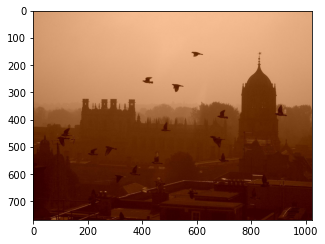

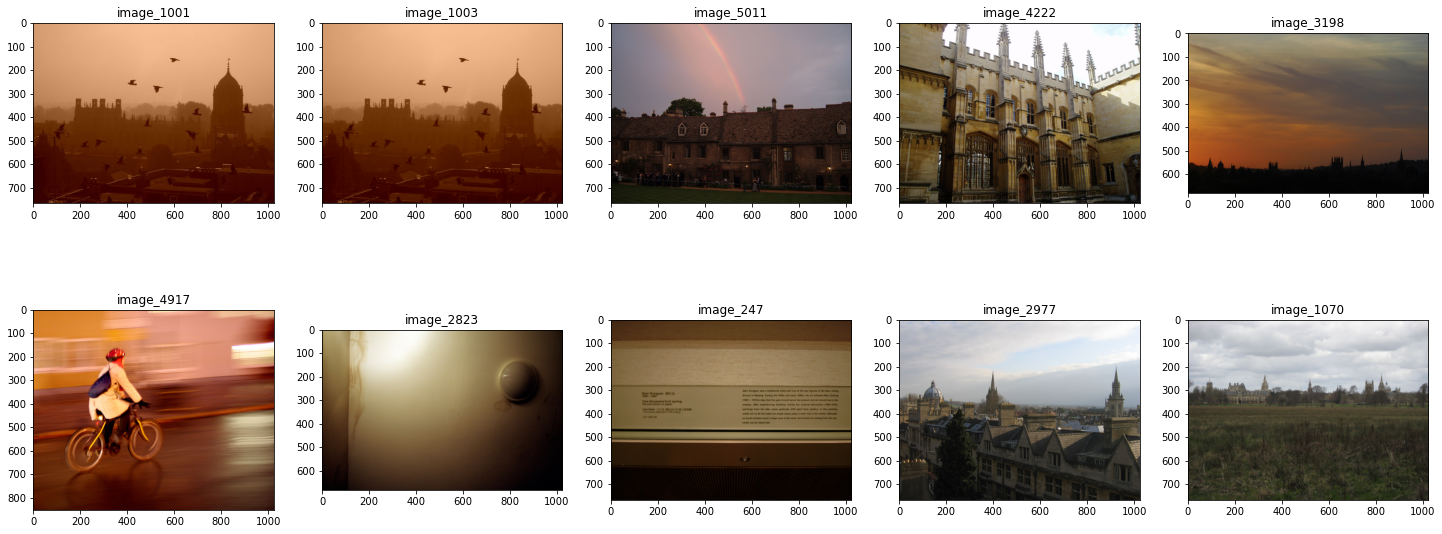

In [19]:
# take the features for the current image, find all similar images in our dataset, 
# and then initialize our list of result images

queryIdx = 1000# Input Index for which images 
MAX_RESULTS = 10

queryFeatures = latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)

# display the query image
plt.figure(figsize=(5,5))
plt.imshow(Image.open(images[queryIdx]))

# loop over the results
fig, axs = plt.subplots(2, 5, figsize=(25,10))
i=0
for (d, j) in results:
    img = Image.open(images[j])
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"image_{j+1}")
    i+=1

In [20]:
testpath = Path('Test_Images')
testdf = pd.DataFrame()

testdf['image'] = [f for f in os.listdir(testpath) if os.path.isfile(os.path.join(testpath, f))]
testdf['image'] = 'Test_Images/' + testdf['image'].astype(str)

testimages = testdf.image.values
test_latent_features = get_latent_features(testimages, transformations)
test_latent_features.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 58.47it/s]


(10, 100)

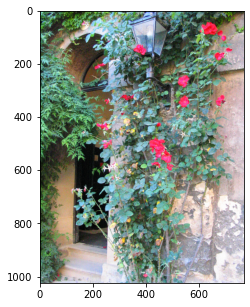

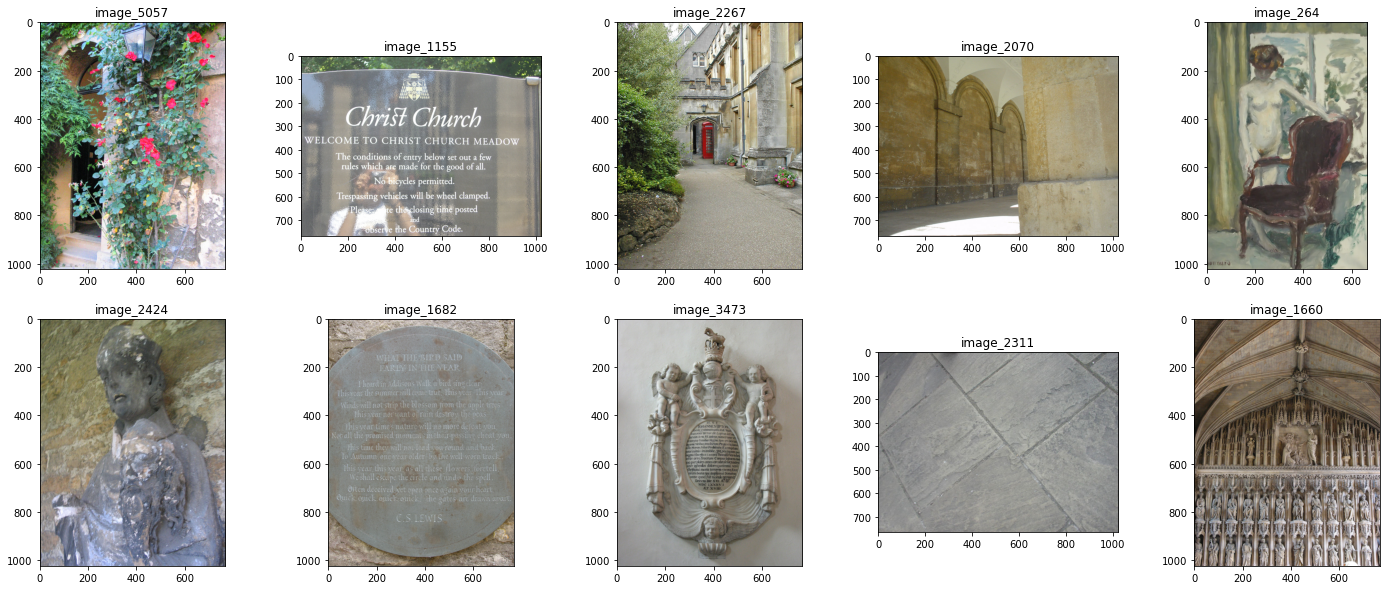

In [21]:
MAX_RESULTS = 10
queryIdx = 3

queryFeatures = test_latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)

# display the query image
plt.figure(figsize=(5,5))
plt.imshow(Image.open(testimages[queryIdx]))

# loop over the results
fig, axs = plt.subplots(2, 5, figsize=(25,10))
i=0
for (d, j) in results:
    img = Image.open(images[j])
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"image_{j+1}")
    i+=1

### 2.2 LSHashing Method

In [22]:
#!pip install lshashpy3
from lshashpy3 import LSHash

## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 100 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# # LSH on all the images
for idx,vec in tqdm(feature_dict.items()):
    lsh.index(vec, extra_data=idx)#vec.flatten()

100%|███████████████████████████████████████████████████████████████████████████| 5063/5063 [00:00<00:00, 21385.27it/s]


In [23]:
## Exporting as pickle
#pickle.dump(lsh, open('lsh.p', "wb"))

In [24]:
def get_similar_item(queryFeatures, feature_dict, lsh_variable, n_items=10):
    response = lsh_variable.query(queryFeatures, num_results=n_items+1, distance_func='euclidean')#hamming
    lists = []
    imgs = []
    for i in range(1, n_items+1):
        lists.append(response[i][0][1])
        imgs.append(np.array(Image.open(images[response[i][0][1]])))
    return lists, imgs

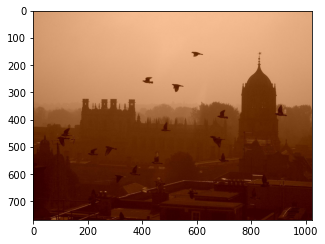

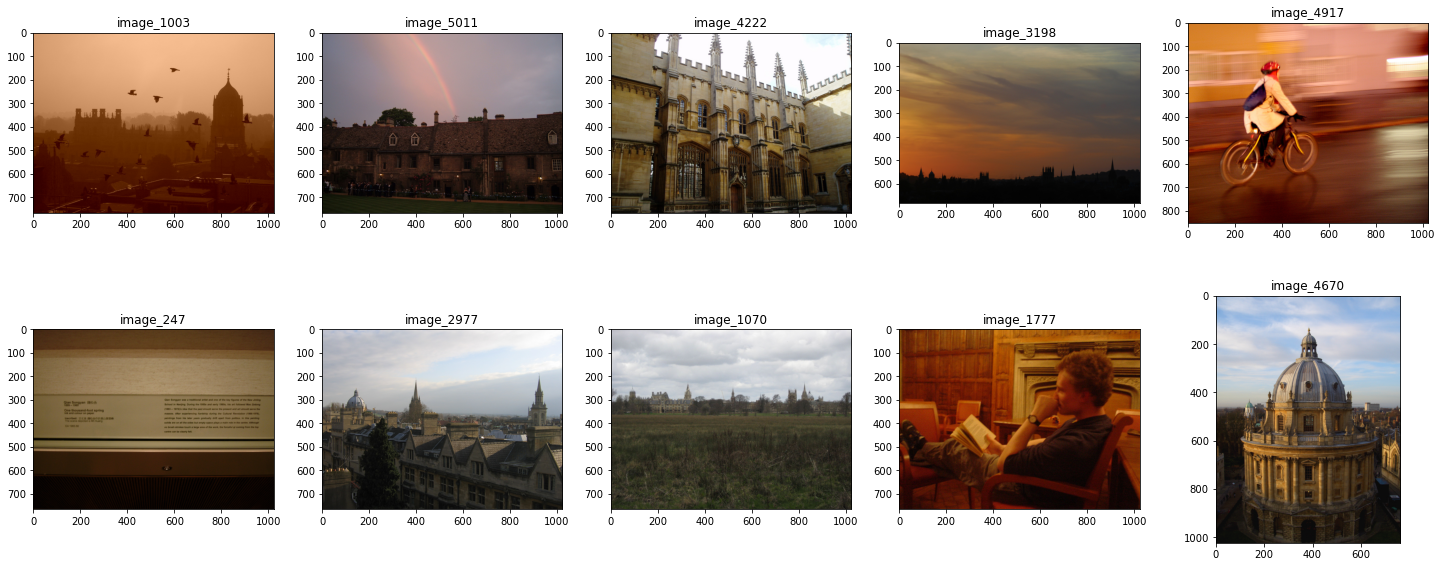

In [25]:
queryIdx = 1000
queryFeatures = latent_features[queryIdx]

lists, results = get_similar_item(queryFeatures, feature_dict, lsh, 10)

# display the query image
plt.figure(figsize=(5,5))
plt.imshow(Image.open(images[queryIdx]))

# loop over the results
fig, axs = plt.subplots(2, 5, figsize=(25,10))
i=0
for j in range(10):
    img = results[j]
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"image_{lists[j]+1}")
    i+=1

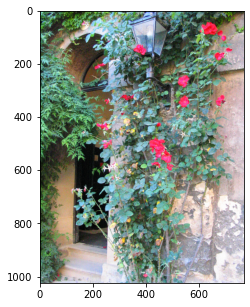

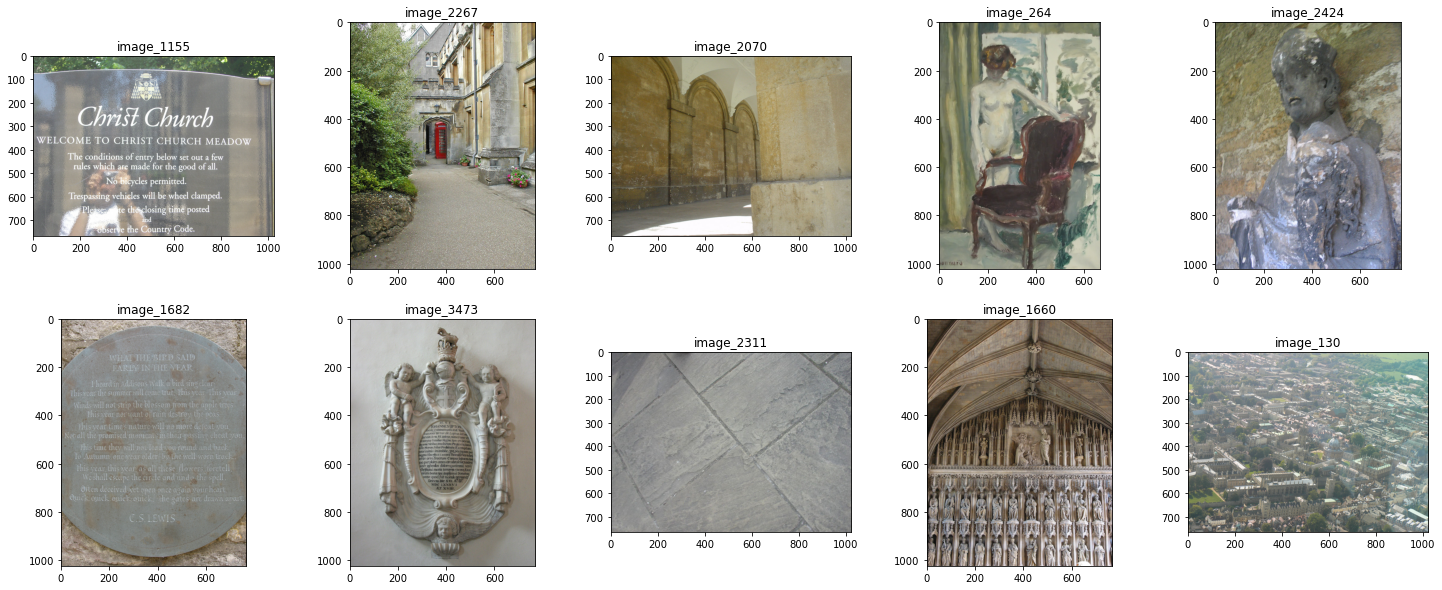

In [26]:
queryIdx = 3
queryFeatures = test_latent_features[queryIdx]

lists, results = get_similar_item(queryFeatures, feature_dict, lsh, 10)

# display the query image
# display the query image
plt.figure(figsize=(5,5))
plt.imshow(Image.open(testimages[queryIdx]))

# loop over the results
fig, axs = plt.subplots(2, 5, figsize=(25,10))
i=0
for j in range(10):
    img = results[j]
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"image_{lists[j]+1}")
    i+=1

# End Notes

- We started with the approach of AutoEncoders for Image Latent Features extraction followed by Image retrieval using Euclidean Distance which was an O(NlogN) approach (Time-Complexity) to Hashing which gave us an ~O(logN) approach

- Another approach was to use Hashing on features obtained from SIFT, SURF, OBS and building the VP Trees ans search the images in it.

![](https://www.pyimagesearch.com/wp-content/uploads/2019/08/image_hashing_search_engine_steps.png)

# Clustering of Images

In [27]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
%matplotlib inline

In [28]:
def get_latent_features1D(images, transformations):
    
    latent_features1d = []
    
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image)).to(device)
        latent_features1d.append(model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy().flatten())
        
    del tensor
    gc.collect()
    return latent_features1d

In [29]:
images = df.image.values
latent_features1d = get_latent_features1D(images, transformations)
latent_features1d = np.array(latent_features1d)

100%|██████████████████████████████████████████████████████████████████████████████| 5063/5063 [01:17<00:00, 65.72it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.14it/s]


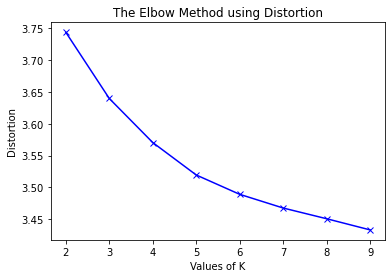

In [34]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(2,10) 
  
for k in tqdm(K): 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(latent_features1d)      
      
    distortions.append(sum(np.min(cdist(latent_features1d, kmeanModel.cluster_centers_, 
                       'euclidean'),axis=1)) / latent_features1d.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(latent_features1d, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / latent_features1d.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.18786983


 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.36it/s]

For n_clusters = 3 The average silhouette_score is : 0.09962411


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.47it/s]

For n_clusters = 4 The average silhouette_score is : 0.09561101


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


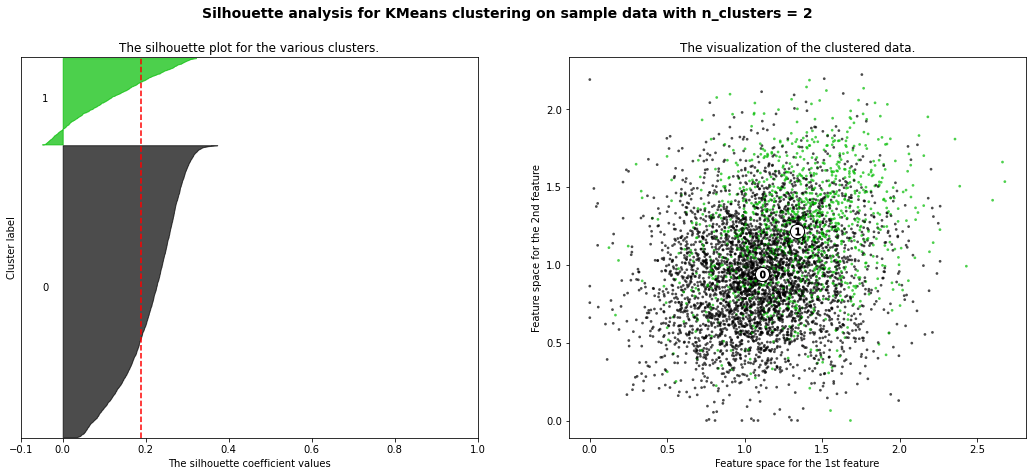

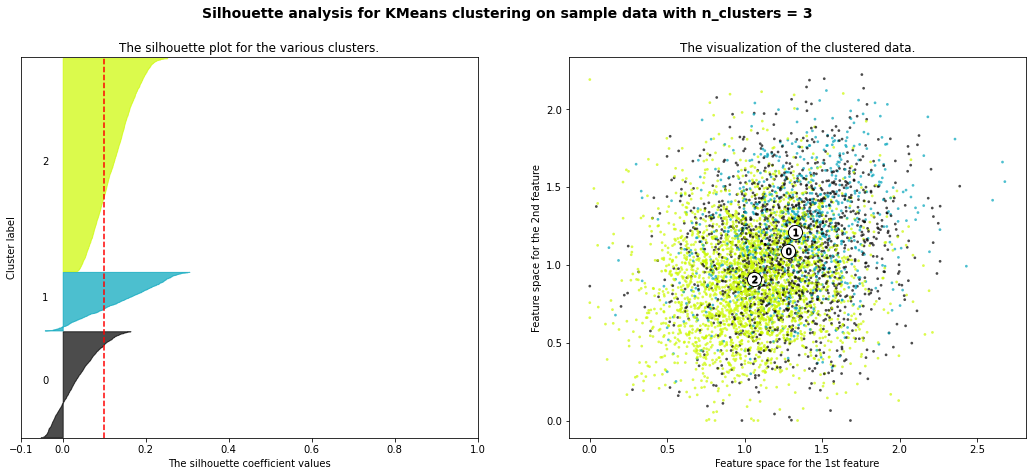

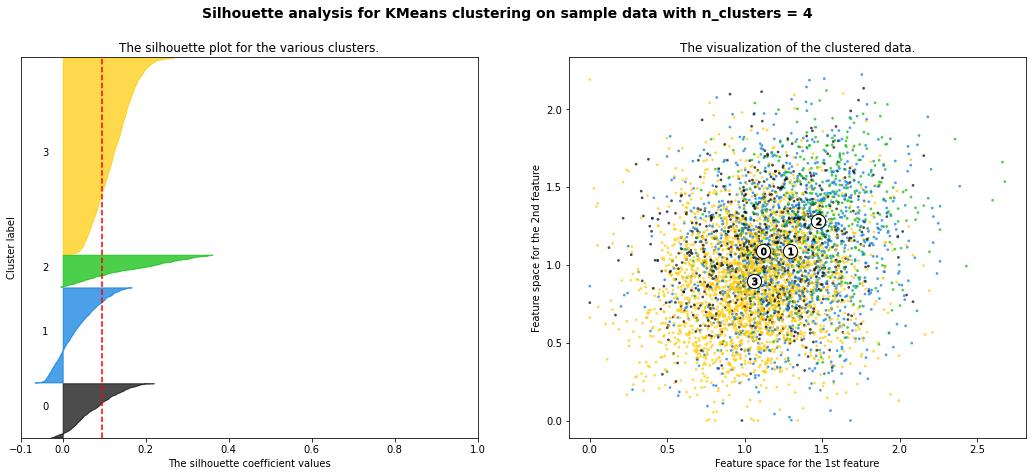

In [31]:
X = np.array(latent_features1d)
K = range(2,5) #https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

for n_clusters in tqdm(K):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Using SIFT/SURF/ORB technique

In [32]:
def build_dictionary(xfeatures2d, images, n_clusters):
    #print('Computing descriptors..')        
    desc_list = []
    
    for image_path in images:
        gray = cv2.imread(image_path,0)
        kp, dsc = xfeatures2d.detectAndCompute(gray, None)
        if dsc is None:
            desc_list.extend(np.zeros((1000,32)))
        else:    
            desc_list.extend(dsc)

    desc = np.array(desc_list)
    #print('Creating BoW dictionary using K-Means clustering with k={}..'.format(n_clusters))
    dictionary = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, verbose=0)
    dictionary.fit(desc)
    
    distortion = sum(np.min(cdist(desc, dictionary.cluster_centers_, 
                      'euclidean'),axis=1)) / desc.shape[0]
    
    return distortion

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\ProgramData\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
 17%|██████████████                                                                      | 1/6 [01:29<07:29, 89.89s/it]C:\ProgramData\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
 33%|████████████████████████████                                                        | 2/6 [02

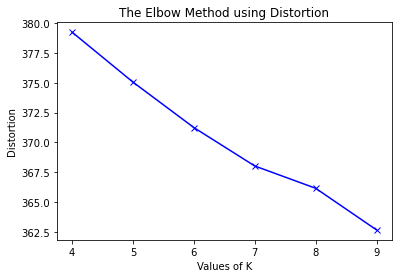

In [33]:
orb = cv2.ORB_create(1000)
images = df.image.values
K = range(4,10)
distortions = []

for k in tqdm(K):
    distortions.append(build_dictionary(orb, images, n_clusters=k))
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 